In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numba import njit

In [2]:
# Give values to measured units
mV = 1e-3
nF = 1e-9
ms = 1e-3
nA = 1e-9

MOhm = 1e6

### Advanced ring model
Note that this 'advanced ring model' isn't a conceptually leap compared to the basic ring model. The basic ring model seemed to have reached a functional endpoint with which I was satisfied. I hence left this unaltered and decided it deserved its own notebook. The advanced ring attractor here however uses a parallellised implementation of the LIFNeuron update. This speeds up the ring attractor drastically.

In [3]:
class LIFNeuron:  
    '''Set the parameters that are common to all LIF neurons'''
    C = 1*nF                              # Membrane capacitance
    Vth = -48*mV                          # Membrane potential threshold value
    Vr = -80*mV                           # Membrane potential reset value
    Vleak = -70*mV                        # Resting membrane potential / leaky reversal potential
    Vsyn_ex = 0*mV                        # Excitatory synaptic reversal potential
    Vsyn_in = -70*mV                      # Inhibitory synaptic reversal potential

    tau_m = 5*ms                          # Membrane time constant
    tau_ref = 2*ms                        # Refractory period
    tau_s_ex = 5*ms                       # Excitatory synaptic time constant
    tau_s_in = 5*ms                       # Inhibitory synaptic time constant
        
    def __init__(self, ID, angle, dt=1*ms, V0=-60*mV, noise_mean=0, noise_std=1*mV):
        '''Initialise instance specifics of LIF neurons'''
        self.id = ID
        
        self.V = V0                                   # Initial membrane potential
        self.dt = dt
        self.t_last_spike = 200*ms                    # Time since last spike
        self.noise_mean = noise_mean                  # Mean of gaussian noise
        self.noise_std = noise_std                    # Standard deviation of gaussian noise
        self.k_ex = 1 / (self.tau_s_ex * np.exp(-1))  # Maximum conductance of an excitatory synapse
        self.k_in = 1 / (self.tau_s_in * np.exp(-1))  # Maximum conductance of an inhibitory synapse
        
        self.angle = angle
        self.synapses = {'ex':{}, 'in':{}}            # Outgoing synapses {neuron ID : weight}
        
        # exc and inh pre-synaptic time delays from last spike, [(time_delay, weight), (...)]
        self.ex_ps_td = [(0, 0)]
        self.in_ps_td = [(0, 0)]
    
    def update(self):
        '''Updates the LIF neuron's state for a single time step'''
        if self.V == 0.0:
            self._hyperpolarize()
        elif self.V >= self.Vth:
            self._depolarize()
        else:
            dV = _updatePotential(self.V, self.C, self.Vleak, self.Vsyn_ex, self.Vsyn_in, 
                                  self.tau_m, self.tau_s_ex, self.tau_s_in, self.dt, self.noise(), 
                                  np.array(self.ex_ps_td), np.array(self.in_ps_td), self.k_ex, self.k_in)
            self.V += dV + self.noise()
            
        # Send time delays to connected neurons
        if self.t_last_spike > self.tau_ref:
            for neuron,weight in self.synapses['ex'].items():
                neuron.ex_ps_td.append((self.t_last_spike, weight))
            for neuron,weight in self.synapses['in'].items():                
                neuron.in_ps_td.append((self.t_last_spike, weight))
        
        self.t_last_spike += self.dt
        
        self.ex_ps_td = [(0, 0)]
        self.in_ps_td = [(0, 0)]
    
    def noise(self):
        '''Return gaussian noise of specified mean and standard deviation'''
        return np.random.normal(self.noise_mean, self.noise_std)
    
    def _hyperpolarize(self):
        '''Set membrane potential to the reset value if an action potential has just been fired'''
        self.V = self.Vr

    def _depolarize(self):
        '''Set membrane potential to 0 if an action potential has been fired'''
        self.V = 0.0
        self._receiveActionPotential()
            
    def _receiveActionPotential(self):
        '''Reset time since the last spike to 0 once an action potential has been fired'''
        self.t_last_spike = 0*ms
        
@njit(cache=True)       
def _updatePotential(V, C, Vleak, Vsyn_ex, Vsyn_in, tau_m, tau_s_ex, tau_s_in, 
                     dt, noise, ex_ps_td, in_ps_td, k_ex, k_in):
    '''Update LIF neuron's membrane potential'''
    I_ex = 0
    I_in = 0
    
    for td, w in ex_ps_td:
        I_ex += k_ex * td * np.exp(-td / tau_s_ex) * (V - Vsyn_ex) * w * 1e-6
    for td, w in in_ps_td:
        I_in += k_in * td * np.exp(-td / tau_s_in) * (V - Vsyn_in) * w * 1e-6
    
    I_L = C * (V - Vleak) / tau_m
    
    dV = (-I_L - I_ex - I_in) / C * dt
    return dV

In [4]:
class RingAttractor:
    def __init__(self, n=256, noise=2*mV, weights=(0.050, 0.100, 0.050, 0.250), fixed_points=0, timesteps=1000, plot=False, random_seed=None):
        '''Initialise paramters of the ring-attractor'''
        self.n = n
        self.noise = noise
        self.weights = weights
        self.fixed_points = fixed_points
        self.timesteps = timesteps
        self.plot = plot
        self.random_seed = random_seed
        
        self.neurons = [LIFNeuron(ID=i, angle=360/n*i, noise_mean=0, noise_std=self.noise) for i in range(n)]
        self.fp_width = 3
        self.fixed_points = self.get_fixed_points()
        self.mid_point = n // 2

        self.connect_with_fixed_points()
        self.flushed = True
        self.raw_data = None
        self.spikes = None

        if random_seed:
            np.random.seed(self.random_seed)

    def simulate(self, source):
        '''Run the ring-attractor simulation'''
        if self.flushed == False:
            warnings.warn("Simulation has not been flushed!")

        potentials = [[] for _ in range(self.n)]
        for t_ in range(self.timesteps):
            for neuron in self.neurons:
                self.input_source(n_of_spikes=5, spike_source=source, start_time=0, neuron=neuron, time=t_)
                neuron.update()
                potentials[neuron.id].append(neuron.V)

        self.process_potentials(potentials)

        if self.plot:
            self.plot_potentials()
    
    def flush(self, neurons=True, fixed_points=True, connections=True):
        '''Reset the model so simulations can be re-run without carrying activity over'''
        if neurons:
            # Create a new list of LIF neurons
            self.neurons = [LIFNeuron(ID=i, angle=360/n*i, noise_mean=0, noise_std=self.noise,) for i in range(n)]
        if fixed_points:
            self.fixed_points=self.get_fixed_points()
        if connections:
            self.connect_with_fixed_points()
        self.flushed = True
        
    def get_fixed_points(self):
        '''Determine fixed points of the ring-attractor by evenly distributing them across the ring'''
        if self.fixed_points == 0:
            return []

        if self.fixed_points == 1:
            return [x for x in range(self.fp_width)]

        index = np.arange(self.n)
        interval = self.n // self.fixed_points

        dist = index % interval
        low = interval // 2 - self.fp_width // 2
        high = interval // 2 + self.fp_width // 2
        
        return index[(dist >= low) & (dist <= high)]
    
    def connect_with_fixed_points(self):
        '''Connects neurons in a ring. Fixed neurons have different weights for excitatory and inhibitory synapses'''
        for neur in self.neurons:
            if neur.id not in self.fixed_points:
                for i in range(1,5):
                    neur.synapses['ex'][self.neurons[(neur.id + i) % self.n]] = self.weights[0]#*np.exp(-i/5)
                    neur.synapses['ex'][self.neurons[neur.id - i]] = self.weights[0]#*np.exp(-i/5)
                    
                for i in range(5,12):
                    neur.synapses['in'][self.neurons[(neur.id + i) % self.n]] = self.weights[1]#*np.exp((-i+5)/(n-1))
                    neur.synapses['in'][self.neurons[neur.id - i]] = self.weights[1]#*np.exp((-i+5)/(n-1))
                    
            else:
                for i in range(1,5):
                    neur.synapses['ex'][self.neurons[(neur.id + i) % self.n]] = self.weights[2]
                    neur.synapses['ex'][self.neurons[neur.id - i]] = self.weights[2]
                    
                for i in range(5,12):
                    neur.synapses['in'][self.neurons[(neur.id + i) % self.n]] = self.weights[3]
                    neur.synapses['in'][self.neurons[neur.id - i]] = self.weights[3]

    def process_potentials(self, potentials):
        '''Creates a dataframe with the time of spiking of each neuron'''
        data = pd.DataFrame(potentials)
        data.index = [self.neurons[i].angle for i in data.index]
        data.index = data.index.astype(int)

        spikes = data == 0.0
        spikes = spikes.astype(int)
        spikes = spikes.apply(lambda x: x * x.index)
        spikes = spikes.replace(0, np.nan)

        self.raw_data = data.copy()
        self.spikes = spikes.copy()

        self.flushed = False

    def input_source(self, n_of_spikes, spike_source, start_time, neuron, time):
        '''Provides input to a specific neuron in the ring'''
        sources = spike_source

        if time > start_time:
            if neuron.id in sources:
                for _ in range(n_of_spikes):
                    neuron.ex_ps_td.append(((time - start_time)*ms, self.weights[0]))


    def plot_potentials(self):
        '''Plot the ring-attractor in a heatmap'''
        _, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(self.raw_data, vmin=-0.08, vmax=0.0, cmap="viridis", xticklabels=self.timesteps//10,
                    yticklabels=12, cbar_kws={'label': "Membrane Potential (V)"}, ax=ax)

        # Draw solid lines in locations on the ring with fixed point neurons
        for target in np.arange(0,len(self.fixed_points),self.fp_width):
            cur_fixed_point = np.mean(self.fixed_points[target:(target+self.fp_width)])
            plt.plot([0,self.timesteps],[cur_fixed_point,cur_fixed_point],color='k')

        # Specify time (in seconds) on the x-axis
        xlabels = [item.get_text() for item in ax.get_xticklabels()]
        divided_xlabels = [str(round(int(xlabel)*ms, 2)) for xlabel in xlabels]
        ax.set_xticklabels(divided_xlabels)

        plt.xlabel("Time (ms)")
        plt.ylabel("Orientation of neuron (degrees)")

        ax.set_title("Number of fixed points: {}\nNoise: {:.3e}\nWeights: {}\nRandom seed: {}".format(
            self.fixed_points, self.noise, self.weights, self.random_seed))
        plt.show()

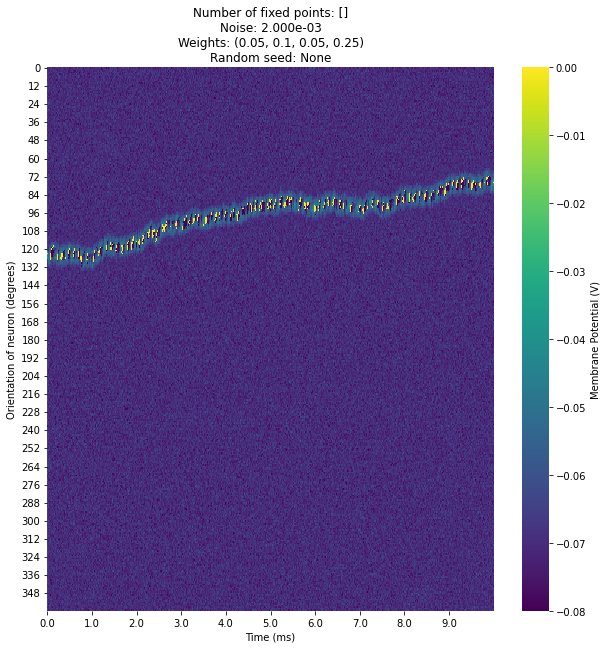

In [5]:
# Simulate a ring-attractor
n = 360
t = np.arange(0, 10, ms)
noise = 2*mV
fp_n = 0
spike_source = [c for c in range(122,127)]

ring = RingAttractor(n=n, noise=noise, weights=(0.050, 0.100, 0.050, 0.250), fixed_points=fp_n, timesteps=len(t), plot=True)
ring.simulate(spike_source)